In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.src_utils import descompress_data, load_transform, get_dataset

tf.random.set_seed(1234)

In [8]:
descompress_data("Chest_X_Ray_DataSets.zip", "chest_xray", "data")

Descompressing files
removing .zip


'Your file is descompressed. Great!!'

In [2]:
train_path = Path("data/chest_xray/train/")
test_path = Path("data/chest_xray/val/")
val_path = Path("data/chest_xray/test/")

train_image_paths = list(map(lambda x: str(x), list(train_path.glob("*/*"))))
val_image_paths = list(map(lambda x: str(x), list(val_path.glob("*/*"))))

train_image_paths[:5]

['data\\chest_xray\\train\\NORMAL\\IM-0115-0001.jpeg',
 'data\\chest_xray\\train\\NORMAL\\IM-0117-0001.jpeg',
 'data\\chest_xray\\train\\NORMAL\\IM-0119-0001.jpeg',
 'data\\chest_xray\\train\\NORMAL\\IM-0122-0001.jpeg',
 'data\\chest_xray\\train\\NORMAL\\IM-0125-0001.jpeg']

In [10]:
train_length = len(train_image_paths)
val_length = len(val_image_paths)
train_length, val_length

(5216, 624)

In [6]:
labels = {"NORMAL" : 0 , "PNEUMONIA" : 1}
invested_labels = {0 : "NORMAL", 1 : "PNEUMONIA"}


def get_labels(path: str) -> int:
    return labels[path.split("\\")[-2]]

train_labels = list(map(lambda x: get_labels(x), train_image_paths))
val_labels = list(map(lambda x: get_labels(x), val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [4]:
train_dataset = get_dataset(paths = train_image_paths , labels = train_labels, batch_size = 32)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


PNEUMONIA


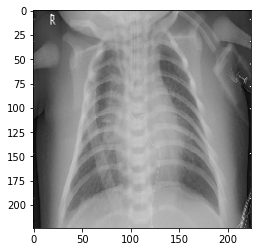

In [5]:
print(invested_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [6]:
val_dataset = get_dataset(paths = val_image_paths , labels = val_labels, batch_size = 32, train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


PNEUMONIA


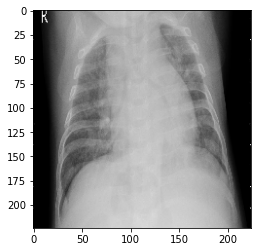

In [7]:
print(invested_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [8]:
backbone = ResNet50V2(input_shape = (224, 224, 3), include_top = False)

model = tf.keras.Sequential([
                            backbone,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(1, activation = "sigmoid")])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [11]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = ["accuracy", tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
)

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = "outputs/best_weights", 
    verbose = 1,
    save_best_only = True,
    save_weights_only = True)

early_stop = tf.keras.callbacks.EarlyStopping(patience = 4)

In [13]:
xray_chest_model = model.fit(
    train_dataset,
    steps_per_epoch = train_length//32,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = val_length//32
)

Epoch 1/8
163/163 [==============================] - 2449s 14s/step - loss: 0.1412 - accuracy: 0.9482 - precision: 0.9647 - recall: 0.9637 - val_loss: 3.2635 - val_accuracy: 0.4128 - val_precision: 0.9231 - val_recall: 0.0633

Epoch 00001: val_loss improved from inf to 3.26346, saving model to outputs\best_weights
Epoch 2/8
163/163 [==============================] - 2168s 13s/step - loss: 0.1035 - accuracy: 0.9605 - precision: 0.9734 - recall: 0.9724 - val_loss: 23.9959 - val_accuracy: 0.3586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss did not improve from 3.26346
Epoch 3/8
163/163 [==============================] - 2172s 13s/step - loss: 0.0758 - accuracy: 0.9701 - precision: 0.9801 - recall: 0.9791 - val_loss: 1.3817 - val_accuracy: 0.7977 - val_precision: 0.7520 - val_recall: 1.0000

Epoch 00003: val_loss improved from 3.26346 to 1.38167, saving model to outputs\best_weights
Epoch 4/8
163/163 [==============================] - 2189s 13s/step - loss: 0

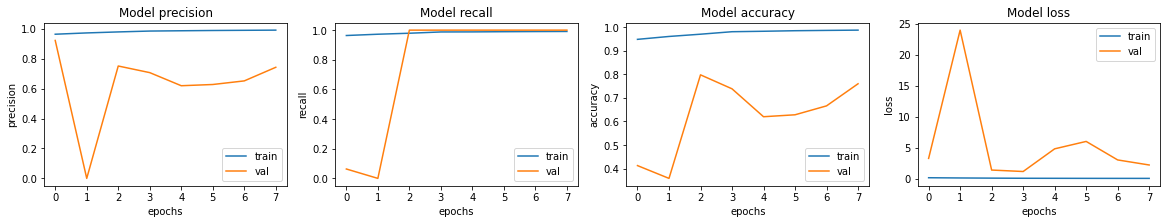

In [18]:
fig, ax = plt.subplots(1 ,4, figsize = (20, 3))
ax = ax.ravel()

for index, metric in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[index].plot(xray_chest_model.history[metric])
    ax[index].plot(xray_chest_model.history["val_" + metric])
    ax[index].set_title(f"Model {metric}")
    ax[index].set_xlabel("epochs")
    ax[index].set_ylabel(metric)
    ax[index].legend(["train", "val"])

In [21]:
# Load the best weights
model.load_weights("outputs/best_weights")
# Save the whole model (weigths + architecture)
model.save("outputs/xray_chest_model")

C:\Users\magar\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: outputs/xray_chest_model\assets


In [3]:
loaded_model = tf.keras.models.load_model("outputs/xray_chest_model")

In [8]:
test_image_path = list(map(lambda x: str(x), list(test_path.glob("*/*"))))
test_labels = list(map(lambda x: get_labels(x), test_image_path))

test_image_paths = tf.convert_to_tensor(test_image_path)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(32)
)

In [10]:
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


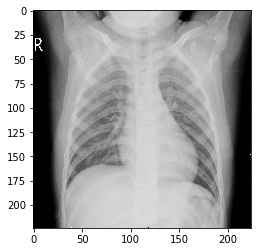

In [12]:
print(invested_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [13]:
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 3s 3s/step - loss: 0.2794 - accuracy: 0.8750 - precision: 0.8000 - recall: 1.0000
 Testing Acc :  0.875
 Testing Precision  0.800000011920929
 Testing Recall  1.0
